In this notebook we use the prime basis given in Wheeler-Xue-Yotov 2011 paper, (Eq 2.18). Note that the dimension of the prime basis is 18 and we don't need to apply any constraint to reduce the dimension. We mapped the prime space of Wheeler et al., to physical element $E$ by Piola transform $\mathcal{P}_E$
$$
\textbf{V}(E) = \mathcal{P}_E( P_1(\hat{E}) + \hat{S}_1(\hat{E}))
$$

In [1]:
using Plots
using LinearAlgebra
using Jacobi
using Test
using SparseArrays
using Random

The prism is defined by cutting a cube $[-1,1]^3$ on diagonal $y=-x$

In [2]:
#============================================ Trilinear Map ==================================================#

function TrilinearMap(Coord_E, xhat, yhat, zhat)
    """
    Input:
    coord_E: coordinate of element E as a 6x3 matrix
    The prism is defined by cutting a cube [-1,1]^3 on diagonal y = -x
    
    Local numbering of Prism
    
        4--------6           z
      / |                    |
    5   |                    |
    |   |                    /----y
    |   |                   /
    |   1 -------3         x
    | /
    2

    """
    
    m = length(xhat)
    N1 = @. 0.25*(-xhat-yhat)*(1-zhat)
    N2 = @. 0.25*(1+xhat)*(1-zhat)
    N3 = @. 0.25*(1+yhat)*(1-zhat)
    N4 = @. 0.25*(-xhat-yhat)*(1+zhat)
    N5 = @. 0.25*(1+xhat)*(1+zhat)
    N6 = @. 0.25*(1+yhat)*(1+zhat)
    N = [N1 N2 N3 N4 N5 N6]
    X = N * Coord_E
    # X(3,m), 1st row x, 2nd row y, 3rd row z
    X = X'
    # gradient of N, [dN/dxhat; dN/dyhat; dN/dzhat]
    GradN = zeros(3,m,6)
    GradN[1,:,:] = @. 0.25*[-(1-zhat) (1-zhat) zeros(m) -(1+zhat) (1+zhat) zeros(m)]
    GradN[2,:,:] = @. 0.25*[-(1-zhat) zeros(m) (1-zhat) -(1+zhat) zeros(m) (1+zhat)]
    GradN[3,:,:] = @. 0.25*[-(-xhat-yhat) -(1+xhat) -(1+yhat) (-xhat-yhat) (1+xhat) (1+yhat)]

    # JT = [[dx/dxhat, dy/dxhat, dz/dxhat],
    #       [dx/dyhat, dy/dyhat, dz/dyhat],
    #       [dx/dzhat, dy/dzhat, dz/dzhat]] (3m x 3)

    JTxhat = GradN[1,:,:] * Coord_E
    dxdxhat = JTxhat[:,1]
    dydxhat = JTxhat[:,2]
    dzdxhat = JTxhat[:,3]
    JTyhat = GradN[2,:,:] * Coord_E
    dxdyhat = JTyhat[:,1]
    dydyhat = JTyhat[:,2]
    dzdyhat = JTyhat[:,3]
    JTzhat = GradN[3,:,:] * Coord_E
    dxdzhat = JTzhat[:,1]
    dydzhat = JTzhat[:,2]
    dzdzhat = JTzhat[:,3]
    # compute det
    j1 = @. (dxdxhat*dydyhat*dzdzhat + dxdyhat*dydzhat*dzdzhat + dxdzhat*dydxhat*dzdyhat)
    j2 = @. (dxdxhat*dydzhat*dzdyhat + dxdyhat*dydxhat*dzdzhat + dxdzhat*dydyhat*dzdxhat)
    detJ = @. j1 - j2
    
    J = zeros(3,m,3)
    J[1,:,:] = [dxdxhat dxdyhat dxdzhat]
    J[2,:,:] = [dydxhat dydyhat dydzhat]
    J[3,:,:] = [dzdxhat dzdyhat dzdzhat]
    
    return X, J, detJ
end

#============================================ Prime Basis ==================================================#

function PrimeBasis(Coord_E, xhat, yhat, zhat)

    """
    Input:
    coord_E: coordinate of physical element E as a 6x3 matrix
    xhat, yhat, zhat: are defined on the reference element Ehat
    and should be given as a vector (xhat=[1] or xhat =[1;1],...)
    
    Return:
    Prime basis: of size (3,m,18) evaluated on xhat,yhat,zhat
    Note the first entries "3", are prime basis in the directions x,y,z
    "m" are the length of xhat,yhat, zhat
    "18" is the dimension of the prime basis
    """
    m = length(xhat)
    # supplements from Wheeler, Xue, & Yotov, 2011
    shat1 = [(2*yhat .* zhat) (zeros(m)) (zeros(m))]
    shat2 = [(zeros(m)) (2*xhat .* zhat) (zeros(m))]
    shat3 = [(zeros(m)) (2*yhat .* zhat) (-zhat.^2)]  
    shat4 = [(2*xhat .* zhat) (zeros(m)) (-zhat.^2)]
    shat5 = [(xhat.^2) (xhat .* yhat) (-3*xhat .* zhat)]
    shat6 = [(yhat .* xhat) (yhat.^2) (-3*yhat .* zhat)]
    
    # X are in E
    X, J, detJ = TrilinearMap(Coord_E, xhat, yhat, zhat)
    
    # we have 18 basis
    # the first 12 is defined on E using x,y,z
    P = zeros(3,m,18)
    P[1,:,1] = (J[1,:,1] .* ones(m)) ./ detJ
    P[2,:,1] = (J[2,:,1] .* ones(m)) ./ detJ
    P[3,:,1] = (J[3,:,1] .* ones(m)) ./ detJ
    P[1,:,2] = (J[1,:,1] .* xhat) ./ detJ
    P[2,:,2] = (J[2,:,1] .* xhat) ./ detJ
    P[3,:,2] = (J[3,:,1] .* xhat) ./ detJ
    P[1,:,3] = (J[1,:,1] .* yhat) ./ detJ
    P[2,:,3] = (J[2,:,1] .* yhat) ./ detJ
    P[3,:,3] = (J[3,:,1] .* yhat) ./ detJ
    P[1,:,4] = (J[1,:,1] .* zhat) ./ detJ
    P[2,:,4] = (J[2,:,1] .* zhat) ./ detJ
    P[3,:,4] = (J[3,:,1] .* zhat) ./ detJ
    P[1,:,5] = (J[1,:,2] .* ones(m)) ./ detJ
    P[2,:,5] = (J[2,:,2] .* ones(m)) ./ detJ
    P[3,:,5] = (J[3,:,2] .* ones(m)) ./ detJ
    P[1,:,6] = (J[1,:,2] .* xhat) ./ detJ
    P[2,:,6] = (J[2,:,2] .* xhat) ./ detJ
    P[3,:,6] = (J[3,:,2] .* xhat) ./ detJ
    P[1,:,7] = (J[1,:,2] .* yhat) ./ detJ
    P[2,:,7] = (J[2,:,2] .* yhat) ./ detJ
    P[3,:,7] = (J[3,:,2] .* yhat) ./ detJ
    P[1,:,8] = (J[1,:,2] .* zhat) ./ detJ
    P[2,:,8] = (J[2,:,2] .* zhat) ./ detJ
    P[3,:,8] = (J[3,:,2] .* zhat) ./ detJ
    P[1,:,9] = (J[1,:,3] .* ones(m)) ./ detJ
    P[2,:,9] = (J[2,:,3] .* ones(m)) ./ detJ
    P[3,:,9] = (J[3,:,3] .* ones(m)) ./ detJ
    P[1,:,10] = (J[1,:,3] .* xhat) ./ detJ
    P[2,:,10] = (J[2,:,3] .* xhat) ./ detJ
    P[3,:,10] = (J[3,:,3] .* xhat) ./ detJ
    P[1,:,11] = (J[1,:,3] .* yhat) ./ detJ
    P[2,:,11] = (J[2,:,3] .* yhat) ./ detJ
    P[3,:,11] = (J[3,:,3] .* yhat) ./ detJ
    P[1,:,12] = (J[1,:,3] .* zhat) ./ detJ
    P[2,:,12] = (J[2,:,3] .* zhat) ./ detJ
    P[3,:,12] = (J[3,:,3] .* zhat) ./ detJ
    
    P[1,:,13] = (J[1,:,1] .* shat1[:,1] + J[1,:,2] .* shat1[:,2] + J[1,:,3] .* shat1[:,3]) ./ detJ
    P[2,:,13] = (J[2,:,1] .* shat1[:,1] + J[2,:,2] .* shat1[:,2] + J[2,:,3] .* shat1[:,3]) ./ detJ
    P[3,:,13] = (J[3,:,1] .* shat1[:,1] + J[3,:,2] .* shat1[:,2] + J[3,:,3] .* shat1[:,3]) ./ detJ

    P[1,:,14] = (J[1,:,1] .* shat2[:,1] + J[1,:,2] .* shat2[:,2] + J[1,:,3] .* shat2[:,3]) ./ detJ
    P[2,:,14] = (J[2,:,1] .* shat2[:,1] + J[2,:,2] .* shat2[:,2] + J[2,:,3] .* shat2[:,3]) ./ detJ
    P[3,:,14] = (J[3,:,1] .* shat2[:,1] + J[3,:,2] .* shat2[:,2] + J[3,:,3] .* shat2[:,3]) ./ detJ

    P[1,:,15] = (J[1,:,1] .* shat3[:,1] + J[1,:,2] .* shat3[:,2] + J[1,:,3] .* shat3[:,3]) ./ detJ
    P[2,:,15] = (J[2,:,1] .* shat3[:,1] + J[2,:,2] .* shat3[:,2] + J[2,:,3] .* shat3[:,3]) ./ detJ
    P[3,:,15] = (J[3,:,1] .* shat3[:,1] + J[3,:,2] .* shat3[:,2] + J[3,:,3] .* shat3[:,3]) ./ detJ

    P[1,:,16] = (J[1,:,1] .* shat4[:,1] + J[1,:,2] .* shat4[:,2] + J[1,:,3] .* shat4[:,3]) ./ detJ
    P[2,:,16] = (J[2,:,1] .* shat4[:,1] + J[2,:,2] .* shat4[:,2] + J[2,:,3] .* shat4[:,3]) ./ detJ
    P[3,:,16] = (J[3,:,1] .* shat4[:,1] + J[3,:,2] .* shat4[:,2] + J[3,:,3] .* shat4[:,3]) ./ detJ

    P[1,:,17] = (J[1,:,1] .* shat5[:,1] + J[1,:,2] .* shat5[:,2] + J[1,:,3] .* shat5[:,3]) ./ detJ
    P[2,:,17] = (J[2,:,1] .* shat5[:,1] + J[2,:,2] .* shat5[:,2] + J[2,:,3] .* shat5[:,3]) ./ detJ
    P[3,:,17] = (J[3,:,1] .* shat5[:,1] + J[3,:,2] .* shat5[:,2] + J[3,:,3] .* shat5[:,3]) ./ detJ

    P[1,:,18] = (J[1,:,1] .* shat6[:,1] + J[1,:,2] .* shat6[:,2] + J[1,:,3] .* shat6[:,3]) ./ detJ
    P[2,:,18] = (J[2,:,1] .* shat6[:,1] + J[2,:,2] .* shat6[:,2] + J[2,:,3] .* shat6[:,3]) ./ detJ
    P[3,:,18] = (J[3,:,1] .* shat6[:,1] + J[3,:,2] .* shat6[:,2] + J[3,:,3] .* shat6[:,3]) ./ detJ
    
    return P
end

#============================================ Normals ==================================================#

function GetNormal(Coord_E, xhat, yhat, zhat, face)

    """
    Input:
    coord_E: coordinate of physical element E as a 6x3 matrix
    xhat, yhat, zhat: are defined on the reference element Ehat
    and should be given as a vector (xhat=[1] or xhat =[1;1],...)
    face: that you want the normal
    
    Return: normals on physical element
    n: of size(3,m)
    le: length of n
    
    Note the face and xhat, yhat, zhat should be consistent.
    
    Based on following numbering:
    left:     nodes 1,2,4,5 at yhat = -1
    back:     nodes 1,3,4,6 at xhat = -1
    diagonal: nodes 2,3,5,6 at xhat = -yhat
    bottom:   nodes 1,2,3   at zhat = -1
    top:      nodes 4,5,6   at zhat = 1
    Local numbering of Prism
    
        4--------6           z
      / |                    |
    5   |                    |
    |   |                    /----y
    |   |                   /
    |   1 -------3         x
    | /
    2
    Since we divide a Hexa numbering are given for both case.
    And still if you call left normal gives you the normal at
    face 1,2,4,5 of the following (I know it is not left, change naming of normal later)
                5
              / |
    6-------4   |
    |       |   | 
    |       |   2
    |       | /
    3-------1
    
    """
    X, J, detJ = TrilinearMap(Coord_E, xhat, yhat, zhat)

    dxdxhat = J[1,:,1]
    dxdyhat = J[1,:,2]
    dxdzhat = J[1,:,3]
    
    dydxhat = J[2,:,1]
    dydyhat = J[2,:,2]
    dydzhat = J[2,:,3]
    
    dzdxhat = J[3,:,1]
    dzdyhat = J[3,:,2]
    dzdzhat = J[3,:,3]

    m = length(xhat)
    
    if face == "left" && yhat == -ones(m)
        
        n1 = @. dydxhat*dzdzhat - dzdxhat*dydzhat
        n2 = @. dzdxhat*dxdzhat - dxdxhat*dzdzhat
        n3 = @. dxdxhat*dydzhat - dydxhat*dxdzhat
        leng = @. sqrt(n1*n1 + n2*n2 + n3*n3)
        n = zeros(3,m)
        n[1,:] = n1 ./ leng
        n[2,:] = n2 ./ leng
        n[3,:] = n3 ./ leng
      
    elseif face == "back" && xhat == -ones(m)
        
        n1 = @. dzdyhat*dydzhat - dydyhat*dzdzhat 
        n2 = @. dxdyhat*dzdzhat - dzdyhat*dxdzhat
        n3 = @. dydyhat*dxdzhat - dxdyhat*dydzhat 
        leng = @. sqrt(n1*n1 + n2*n2 + n3*n3)
        n = zeros(3,m)
        n[1,:] = n1 ./ leng
        n[2,:] = n2 ./ leng
        n[3,:] = n3 ./ leng
    
    elseif face == "diagonal" && xhat == -yhat
        #dxdshat = -dxdxhat + dxdyhat, ...
        dxdshat = J[1,:,2] - J[1,:,1]
        dydshat = J[2,:,2] - J[2,:,1]
        dzdshat = J[3,:,2] - J[3,:,1]
        
        n1 = @. dydshat*dzdzhat - dzdshat*dydzhat
        n2 = @. dzdshat*dxdzhat - dxdshat*dzdzhat
        n3 = @. dxdshat*dydzhat - dydshat*dxdzhat
        leng = @. sqrt(n1*n1 + n2*n2 + n3*n3)
        n = zeros(3,m)
        n[1,:] = n1 ./ leng
        n[2,:] = n2 ./ leng
        n[3,:] = n3 ./ leng
    
    elseif face == "top" && zhat == ones(m)
        
        n1 = @. dydxhat*dzdyhat - dzdxhat*dydyhat 
        n2 = @. dzdxhat*dxdyhat - dxdxhat*dzdyhat 
        n3 = @. dxdxhat*dydyhat - dydxhat*dxdyhat 
        leng = @. sqrt(n1*n1 + n2*n2 + n3*n3)
        n = zeros(3,m)
        n[1,:] = n1 ./ leng
        n[2,:] = n2 ./ leng
        n[3,:] = n3 ./ leng
    
    elseif face == "bottom" && zhat == -ones(m)
        
        n1 = @. dzdxhat*dydyhat - dydxhat*dzdyhat
        n2 = @. dxdxhat*dzdyhat - dzdxhat*dxdyhat
        n3 = @. dydxhat*dxdyhat - dxdxhat*dydyhat 
        leng = @. sqrt(n1*n1 + n2*n2 + n3*n3)
        n = zeros(3,m)
        n[1,:] = n1 ./ leng
        n[2,:] = n2 ./ leng
        n[3,:] = n3 ./ leng
    else
        error("face is not defined")
    end

    return n, leng
end

#============================================ Nodal Basis ==================================================#

function VondermondeMat(Coord_E)
    """
    Input:
    coord_E: coordinate of physical element E as a 6x3 matrix
    
    Return:
    VM of size(18,18)
    """
    # get the normals
    nl, le = GetNormal(Coord_E, [0.], [-1.],[0.],"left")
    nd, le = GetNormal(Coord_E, [0.], [0.],[0.],"diagonal")
    nbt, le = GetNormal(Coord_E, [-0.5], [-0.5],[-1.],"bottom")
    nt, le = GetNormal(Coord_E, [-0.5], [-0.5],[1.],"top")
    nbk, le = GetNormal(Coord_E, [-1.], [0.],[0.],"back")
    normals = [nbt nbt nbt nl nl nl nl nd nd nd nd nbk nbk nbk nbk nt nt nt]
    nd1 = [-1.;-1.;-1.]
    nd2 = [1.;-1.;-1.]
    nd3 = [-1.;1.;-1.]
    nd4 = [-1.;-1.;1.]
    nd5 = [1.;-1.;1.]
    nd6 = [-1.;1.;1.]
    nodes = [nd1 nd2 nd3 nd1 nd2 nd4 nd5 nd2 nd3 nd5 nd6 nd1 nd3 nd4 nd6 nd4 nd5 nd6]
    # vondermonde matrix, V_ij = phi_j(x_i).n_i
    VM = zeros(18,18)
    for i=1:18 # loop over dof
        for j=1:18 # loop over prime basis
            P = PrimeBasis(Coord_E, [nodes[1,i]], [nodes[2,i]], [nodes[3,i]])
            VM[i,j] = P[1,1,j]*normals[1,i] + P[2,1,j]*normals[2,i] + P[3,1,j]*normals[3,i]
        end
    end

    return VM
end

function GetNodalBasis(Coord_E, xhat, yhat, zhat)
   
    """
    This function returns Nodal basis as a (3,m,18) array, m = length(xhat)
    Input:
    coord_E: coordinate of physical element E as a 6x3 matrix
    xhat,yhat,zhat (vector of size m): defined on reference element Ehat
    
    Return:
    Nhat of size(3,m,18): Nodal basis for prism
    The order of these 18 nodal basis are:
    1-3:   dofs on bottom face,   nodes 1,2,3
    4-7:   dofs on left face,     nodes 1,2,4,5
    8-11:  dofs on diagonal face, nodes 2,3,5,6
    12-15: dofs on back face,     nodes 1,3,4,6
    16-18: dofs on top face,      nodes 4,5,6
    
    Local Numbering of dof for the following 
    
        4--------6           z
      / |                    |
    5   |                    |                 
    |   |                    /----y 
    |   |                   /
    |   1 -------3         x
    | /
    2   
    
    Since we divide a Hexa numbering are given for both case
                5
              / |
    6-------4   |
    |       |   | 
    |       |   2
    |       | /
    3-------1
    
    """
    
    VM = VondermondeMat(Coord_E)
    P = PrimeBasis(Coord_E, xhat, yhat, zhat)
    invVM = inv(VM)
    
    m = length(xhat)
    Nhat = zeros(3,m,18)
    Nhat[1,:,:] = P[1,:,:] * invVM
    Nhat[2,:,:] = P[2,:,:] * invVM
    Nhat[3,:,:] = P[3,:,:] * invVM
    
    return Nhat
end

#====================================== Divergence of Nodal Basis =============================================#

function GetDivNodalBasis(Coord_E)
    """This function returns the divergence of Nodal basis as a (1,18) array
    Input:
    ------
    coord_E: coordinate of element E as 6x3 array

    Output:
    -------
    Dhat: the divergence of nodal basis computed at [xhat,yhat,zhat]
    shape (1,18)
    """
    VM = VondermondeMat(Coord_E)
    # This is the divergence of prime basis 
    divV = [0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
    invVM = inv(VM)
    Dhat = divV * invVM

    return Dhat
end

GetDivNodalBasis (generic function with 1 method)

In [3]:
function PlotElem(coord_E)
    """
    Input:
    coord_E: coordinate of physical element E as a 6x3 matrix
    
    Return:
    3D view and top view of the element
    """
    
    x = coord_E[:,1]
    y = coord_E[:,2]
    z = coord_E[:,3]
    nodes = [1 2 3 1 4 5 6 4]
    n = length(nodes)
    xx = zeros(n,1)
    yy = zeros(n,1)
    zz = zeros(n,1)
    for j =1:n
        xx[j] = x[nodes[j]] 
        yy[j] = y[nodes[j]] 
        zz[j] = z[nodes[j]]
    end
    plot(xx,yy,zz,color="black",legend=false)
    xx2 = zeros(2,1)
    yy2 = zeros(2,1)
    zz2 = zeros(2,1)
    xx2[1] = x[2]; xx2[2] = x[5]
    yy2[1] = y[2]; yy2[2] = y[5]
    zz2[1] = z[2]; zz2[2] = z[5]
    
    xx3 = zeros(2,1)
    yy3 = zeros(2,1)
    zz3 = zeros(2,1)
    xx3[1] = x[3]; xx3[2] = x[6]
    yy3[1] = y[3]; yy3[2] = y[6]
    zz3[1] = z[3]; zz3[2] = z[6]
    
    plot!(xx2,yy2,zz2,color="black",legend=false)
    p2 = plot!(xx3,yy3,zz3,color="black",legend=false, title = "3D view")
    
    # to see from top 
    # bottom face
    nodes = [1 2 3 1]
    n = length(nodes)
    xb = zeros(n,1)
    yb = zeros(n,1)
    for j =1:n
        xb[j] = x[nodes[j]] 
        yb[j] = y[nodes[j]] 
    end
    # top face
    nodes = [4 5 6 4]
    n = length(nodes)
    xt = zeros(n,1)
    yt = zeros(n,1)
    for j =1:n
        xt[j] = x[nodes[j]] 
        yt[j] = y[nodes[j]] 
    end
    plot(xb,yb,color="black",legend=false)
    pp=plot!(xt,yt,color="black",legend=false, title = "Top View")
    
    plot(p2,pp)
    
end

PlotElem (generic function with 1 method)

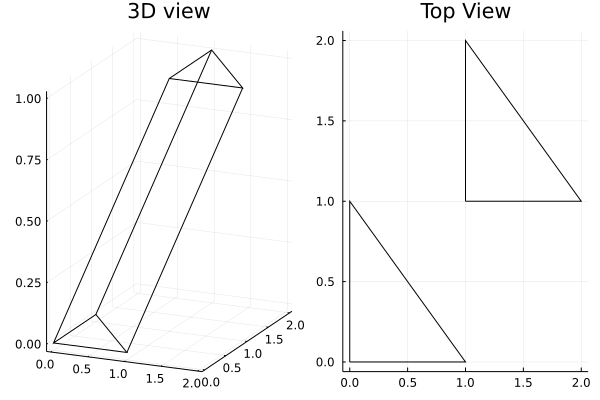

In [4]:
# unstructured element
coord_E = [0. 0. 0.;1. 0. 0.;0. 1. 0.;1. 1. 1.;2. 1. 1.;1. 2. 1]
# reference element
#coord_E = [-1. -1. -1.;1. -1. -1.;-1. 1. -1.;-1. -1. 1.;1. -1. 1.;-1. 1. 1.]
PlotElem(coord_E)

In [5]:
include("GetQuadratureTriangle.jl") # returns w, q for integration over triangle (-1,-1), (1,-1), (-1,1)
#See test integration for example. Input is Q_tri which is the number of quadrature in 2D triangle.
# No.of Q_tri in 2D for above function can be: 1, 3, 4, 6, 7, 12, 13, 16, 19, 25 
# which is accurate for polynomial degree of : 1, 2, 3, 4, 5, 6,  7,  8,  9, 10

function GetQuadrature2D(Q)
    """
    Input:
    Q: number of quadrature points in 1D over [-1,1]
    
    Return:Gauss Quadrature over [-1,1]^2
    qx:
    qy:
    w2:
    """
    # 1D Gauss
    alpha = 0.0
    beta = 0.0
    q = zgj(Q, alpha, beta)
    w = wgj(q, alpha, beta)
    
    w2 = zeros(Q*Q)
    qx = zeros(Q*Q)
    qy = zeros(Q*Q)
    for i=1:Q
        for j=1:Q
            k = (i-1)*Q +j
            qx[k] = q[j]
            qy[k] = q[i]
            w2[k] = w[j]*w[i]
        end
    end
    return w2, qx, qy
end

function Legendre2D(x,y,i,j)
    # Legendre2D define on [-1,1]^2
    return legendre(x,i) .* legendre(y,j)
end

function Dubiner(x,y,i,j)
    # Dubiner polynomial defined on triangle (-1,-1),(1,-1),(-1,1)
    eta1 = 2*(1 .+ x) ./ clamp.(1 .- y,1e-12,10) .- 1
    eta2 = y
    D    = jacobi.(eta1, i, 0, 0)
    D   *= (0.5*(1 .- eta2)) .^i
    D   *= jacobi.(eta2, j, 2*i+1, 0)
    return D
end


Dubiner (generic function with 1 method)

In the following we compute 
$$
C_{i,j}^q=\int_{\partial E} \textbf{v}\cdot\textbf{n} \, L_i(s) L_j(t) dA, \quad C_{i,j}^t = \int_{\partial E} \textbf{v}\cdot\textbf{n} \, D_{i,j}(s,t) dA
$$
where $L_i$ is Legendre polynomial in 1D, $D_{i,j}$ is Dubiner polynomial on traingle domain, $s,t$ are the coordinate on a face, $\textbf{n}$ is the normal on the face $\partial E$, $\textbf{v}$ is the nodal basis with dimension 18. So the output of the above integral is a vector of size 18 for each $(i,j)$

In [6]:
function IntegrateNormalTrace(i,j,coord_E, face, Q1d_quad, Q_tri)
    """
    Input:
    i,j: degrees of Legendre polynomials L_i(s)L_j(t) or Dubiner_{i,j}
    coord_E: physical coordinate of element E
    face: face that you want to compute the normal component of the trace
    Q1d_quad: No. pts in 1D for integration over quad faces
    Q_tri: No. pts in 2D for integration over triangle faces
    
    Return:
    a vector of size 18: which is the result of int{N.n * L_i(s)L_j(t)}dA

    local numbering of Prism
    
        4--------6           z
      / |                    |
    5   |                    |
    |   |                    /----y
    |   |                   /
    |   1 -------3         x
    | /
    2

    """
    # get quadrature on [-1,1]^2
    ww, q1, q2 = GetQuadrature2D(Q1d_quad)
    m1 = -ones(Q1d_quad*Q1d_quad)
    p1 = ones(Q1d_quad*Q1d_quad)
    
    # get quadrature on triangle (-1,-1), (1,-1), (-1,1)
    wwt, qt = GetQuadratureTriangle(Q_tri)
    q1t = qt[:,1]
    q2t = qt[:,2]
    m1t = -ones(Q_tri)
    p1t = ones(Q_tri)
    
    # left face includes nodes 1,2,4,5 at yhat = -1
    if face == "left"
        n, le = GetNormal(coord_E, q1, m1, q2, "left")
        N = GetNodalBasis(coord_E, q1, m1, q2)
        Ndotn = N[1,:,:] .* n[1,:] + N[2,:,:] .* n[2,:] + N[3,:,:] .* n[3,:]
        trace = Ndotn' *(ww .* le .* Legendre2D.(q1,q2,i,j))
        
    # back face includes nodes 1,3,4,6 at xhat = -1
    elseif face == "back"
        n, le = GetNormal(coord_E, m1, q1, q2, face)
        N = GetNodalBasis(coord_E,m1, q1, q2)
        Ndotn = N[1,:,:] .* n[1,:] + N[2,:,:] .* n[2,:] + N[3,:,:] .* n[3,:]
        trace = Ndotn' *(ww .* le .* Legendre2D.(q1,q2,i,j))
        
    # diagonal face includes nodes 2,3,5,6 at xhat = -yhat
    elseif face == "diagonal"
        n, le = GetNormal(coord_E, -q1, q1, q2, face)
        N = GetNodalBasis(coord_E, -q1, q1, q2)
        Ndotn = N[1,:,:] .* n[1,:] + N[2,:,:] .* n[2,:] + N[3,:,:] .* n[3,:]
        trace = Ndotn' *(ww .* le .* Legendre2D.(q1,q2,i,j))  
    
    # top face includes nodes 4,5,6 at zhat = 1
    elseif face == "top"
        n, le = GetNormal(coord_E, q1t, q2t, p1t, face)
        N = GetNodalBasis(coord_E,q1t, q2t, p1t)
        Ndotn = N[1,:,:] .* n[1,:] + N[2,:,:] .* n[2,:] + N[3,:,:] .* n[3,:]
        trace = Ndotn' *(wwt .* le .* Dubiner.(q1t,q2t,i,j))
        
    # bottom face includes nodes 1,2,3 at zhat = -1
    elseif face == "bottom"
        n, le = GetNormal(coord_E, q1t, q2t, m1t, face)
        N = GetNodalBasis(coord_E,q1t, q2t, m1t)
        Ndotn = N[1,:,:] .* n[1,:] + N[2,:,:] .* n[2,:] + N[3,:,:] .* n[3,:]
        trace = Ndotn' *(wwt .* le .* Dubiner.(q1t,q2t,i,j))
    else
        error("face is not defined")
    end
    
    return trace
    
end

IntegrateNormalTrace (generic function with 1 method)

In [7]:
function NormalTrace(coord_E, face, Q1d_quad, Q_tri)
    """
    Input:
    coord_E: physical coordinate of element E
    face: face that you want the normal trace
    Q1d_quad: No. pts in 1D for integration over quad faces
    Q_tri: No. pts in 2D for integration over triangle faces
    
    Return:
    Computed normal trace for all faces with different (i,j)
    """
    
    # On each quad face we compute trace_i,j
    # for (i,j) = (2,0),(2,1),(2,2),(1,2),(0,2) 
    # On triangle face we have above (i,j)+(1,1)
    
    n = [2 2 2 1 0]
    N = length(n)
    
    if face == "top" || face == "bottom"
        # 6 constraint, 18 dim
        L = zeros(N+1,18)
        for j = 1:N # loop over legendre_i,j
            trace = IntegrateNormalTrace(n[j], n[N+1-j], coord_E, face, Q1d_quad, Q_tri)
            L[j,:] = trace
        end
        L[N+1,:] = IntegrateNormalTrace(1, 1, coord_E, face, Q1d_quad, Q_tri)
    else
        # 5 constraint, 18 dim
        L = zeros(N,18)
        for j = 1:length(n) # loop over legendre_i,j
            trace = IntegrateNormalTrace(n[j], n[N+1-j], coord_E, face, Q1d_quad, Q_tri)
            L[j,:] = trace
        end
    end
    
    return L
end

NormalTrace (generic function with 1 method)

# Test Normal Trace
We check the normal component of the trace in the following for plotted element above. The output of the NormalTrace function which is the matrix of size (5,18) for quad faces and (6,18) for triangle faces must be zero.

In [8]:
function TestNormalTrace(coord_E, err)

@testset "TestNormalTrace" begin
    
    Q1d_quad = 5
    Q_tri = 19
    trace = NormalTrace(coord_E, "left", Q1d_quad, Q_tri)
    # check if they are zero
    for i = 1:size(trace,1)
        for j = 1:size(trace,2)
            @test isapprox(trace[i,j], 0.;atol=err)
        end
    end
    
    trace = NormalTrace(coord_E, "back", Q1d_quad, Q_tri)
    # check if they are zero
    for i = 1:size(trace,1)
        for j = 1:size(trace,2)
            @test isapprox(trace[i,j], 0.;atol=err)
        end
    end
    
    trace = NormalTrace(coord_E, "diagonal", Q1d_quad, Q_tri)
    # check if they are zero
    for i = 1:size(trace,1)
        for j = 1:size(trace,2)
            @test isapprox(trace[i,j], 0.;atol=err)
        end
    end
    
    trace = NormalTrace(coord_E, "top", Q1d_quad, Q_tri)
    # check if they are zero
    for i = 1:size(trace,1)
        for j = 1:size(trace,2)
            @test isapprox(trace[i,j], 0.;atol=err)
        end
    end
    
    trace = NormalTrace(coord_E, "bottom", Q1d_quad, Q_tri)
    # check if they are zero
    for i = 1:size(trace,1)
        for j = 1:size(trace,2)
            @test isapprox(trace[i,j], 0.;atol=err)
        end
    end
    
end
    return
end

TestNormalTrace (generic function with 1 method)

# For the following element test passes!
For the following element we can see the normal trace is zero, i.e., $\textbf{v}\cdot\textbf{n}\Big |_{\partial E} \subset P_1(\partial E)$ since we . Note that we only changed the $z$ componenet of above element from 1 to 1.1. That's why we need to bulid our enrichment vectors.

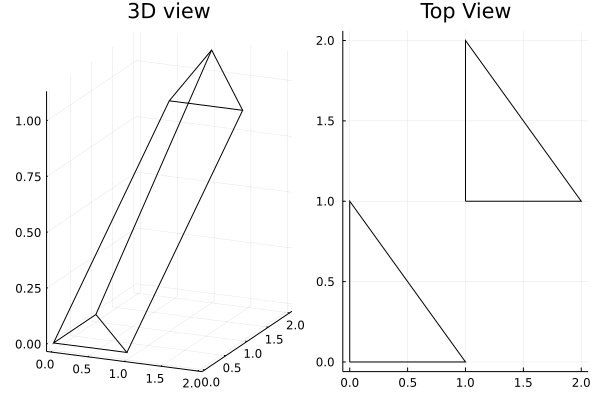

In [9]:
# unstructured element
coord_E = [0. 0. 0.;1. 0. 0.;0. 1. 0.;1. 1. 1.;2. 1. 1.;1. 2. 1.1]
PlotElem(coord_E)

In [10]:
TestNormalTrace(coord_E,1e-14)

Test Summary:   | Pass  Total
TestNormalTrace |  486    486


In the following we plot the maximum of normal trace for a specific mesh distribution.

In [11]:
#===================================== Connectivity of nodes and faces =========================================#

function GetConnectivity(nx, ny, nz)
    """
    This functions works for nz = 1 right now. TODO: extend for general nz!
    This function returns the connectivity array based on face and nodes
    Input:
    ------
    nx: number of hexa element in x direction
    ny: number of hexa element in y direction
    nz: number of hexa element in z direction
    we multiply nx by 2, since we cut our hexa in y=-x
    Output:
    ------
    IENf: connectivity array of size 5x(numelem) based on face numbering.
    We need IENf for assembly
    IENn: connectivity array of size 6x(numelem) based on node numbering.
    We need IENn to find the coordinate of nodes in assembly
    """
    # number of nodes in x-direction
    ndx = nx + 1
    # number of nodes in y-direction
    ndy = ny + 1
    # number of nodes in z-direction
    ndz = nz + 1
    # number of element (divide each hexa by 2 prism)
    nqx = nx # I need nqx later which is number of hexa element in x
    nx = 2*nqx
    num_elem = nx*ny*nz

    # connectivity of the nodes
    IENn = zeros(Int64,6,num_elem)
    el1 = [1;2;ndx+1;ndx*ndy+1;ndx*ndy+2;ndx*ndy+ndx+1]
    el2 = [ndx+2;ndx+1;2;ndx*ndy+ndx+2;ndx*ndy+ndx+1;ndx*ndy+2]
    for k = 1:nz
        e1 = el1 .+ (k-1)*ndx*ndy
        e2 = el2 .+ (k-1)*ndx*ndy
        for j=1:ny
            for i=1:nx
                ele = (k-1)*nx*ny + (j-1)*nx + i
                if isodd(ele)
                    IENn[:,ele] = e1
                    e1 .+= 1
                else
                    IENn[:,ele] = e2
                    e2 .+= 1
                end
            end
            e1 .+= 1
            e2 .+= 1
        end
    end

    # connectivity of the faces
    # for 1 layer of mesh in z direction number of faces
    num_face_z1 = (ndx*ny*1) + (ndy*nqx*1) + nqx*ny*1 + 2*nqx*ny*2
    IENf = zeros(Int64,5,num_elem)
    lz = nx*ny+ny*ndx+ny*nqx+nqx*ndy
    r1 = ndx+nx
    fac1 = [1;nx*ny+1;nx*ny+ndx+1;nx*ny+ndx;lz+1]
    fac2 = [2;nx*ny+1+r1;nx*ny+ndx+1;nx*ny+ndx+2;lz+2]
    fx = [2;1;2;2;2]
    fy = [0;ndx+nqx;nqx+1;nqx+1;0]
    for k = 1:nz
        f1 = fac1 .+ (k-1)*(num_face_z1 - nx*ny)
        f2 = fac2 .+ (k-1)*(num_face_z1 - nx*ny)
        for j = 1:ny
            for i=1:nqx
                ele1 = (k-1)*nx*ny + (j-1)*nx + 2*i-1
                ele2 = (k-1)*nx*ny + (j-1)*nx + 2*i
                IENf[:,ele1] = f1
                IENf[:,ele2] = f2
                f1 += fx
                f2 += fx
            end
            f1 += fy
            f2 += fy
        end
    end

    return IENf, IENn
end

#===================================== Coordinates of Nodes over [0,1]^3 =======================================#

function GetCoordNodes(mesh, nx, ny, nz, a, b, c,theta_z)
    """
    This functions returns the coordinate of all nodes.
    We create a box of size [0,a]x[0,b]x[0,c] (in x,y,z directions).
    Then we mesh with nx, ny, nz elements.
    Note we dived each hexa by 2. So we have 2*nx*ny*nz prism elements
    Input:
    mesh : can be "uniform", "nonuniform" or "random"
    nx:   integer
            number of hex elements in the x direction.
    ny:   integer
            number of hex elements in the y direction.
    nz:   integer
            number of hex elements in the z direction.
    a, b, c: size of the box
    theta_z: degree
            is the angle of box and z-axis for "nonuniform" mesh
            theta_z = 0 gives the same mesh as uniform
    
    Return:
    Coord_Ns: coordinates of nodes of a mesh as (x,y,z)
    """
    ndx = nx + 1
    ndy = ny + 1
    ndz = nz + 1
    # number of nodes in xy plane
    num_ndxy = ndx*ndy
    # total numbers of node
    num_nd = ndx*ndy*ndz
    
    x = zeros(num_nd)
    y = zeros(num_nd)
    z = zeros(num_nd)
    meshgrid(x1, y1) = (repeat(x1, outer=length(y1)), repeat(y1, inner=length(x1)))
    slope_z = tand(theta_z)
    zz = LinRange(0,1,ndz)
    hx = a/nx
    hy = b/ny
    hz = c/nz
    h = maximum([hx hy hz])
    Random.seed!(1234)
    rand_ndz = rand(num_ndxy,1)*hz/2 .- hz/4
    
    if mesh == "uniform"
        
        x2, y2 = meshgrid(LinRange(0,a,ndx), LinRange(0,b,ndy))
        z2 = LinRange(0,c,ndz)
    
        for i=1:ndz
            x[1 + (i-1)*num_ndxy:i*num_ndxy] = x2
            y[1 + (i-1)*num_ndxy:i*num_ndxy] = y2
            z[1 + (i-1)*num_ndxy:i*num_ndxy] = z2[i]*ones(num_ndxy)
        end
        
    elseif mesh == "nonuniform"
        for i=1:ndz 
            z2 = LinRange(0,c,ndz)

            y0 = slope_z*zz[i]
            x0 = slope_z*zz[i]
            
            x2, y2 = meshgrid(LinRange(x0,a+x0,ndx), LinRange(y0,b+y0,ndy))
        
            x[1 + (i-1)*num_ndxy:i*num_ndxy] = x2
            y[1 + (i-1)*num_ndxy:i*num_ndxy] = y2
            z[1 + (i-1)*num_ndxy:i*num_ndxy] = z2[i]*ones(num_ndxy)
        end
        
    elseif mesh == "terrain"
        x2, y2 = meshgrid(LinRange(0,a,ndx), LinRange(0,b,ndy))
        for i=1:ndz
            x[1 + (i-1)*num_ndxy:i*num_ndxy] = x2
            y[1 + (i-1)*num_ndxy:i*num_ndxy] = y2
            z[1 + (i-1)*num_ndxy:i*num_ndxy] = 0.25*(sin.(x2) + sin.(y2)) .+ (i-1)*hz
        end
    
    elseif mesh == "random"                
        x2, y2 = meshgrid(LinRange(0,a,ndx), LinRange(0,b,ndy))
        z2 = LinRange(0,c,ndz)
        for i=1:ndz
            x[1 + (i-1)*num_ndxy:i*num_ndxy] = x2
            y[1 + (i-1)*num_ndxy:i*num_ndxy] = y2
            if i == 1
                z[1 + (i-1)*num_ndxy:i*num_ndxy] = 0*ones(num_ndxy)
            elseif i == ndz
                z[1 + (i-1)*num_ndxy:i*num_ndxy] = z2[i]*ones(num_ndxy)
            else
                #z[1 + (i-1)*num_ndxy:i*num_ndxy] = z2[i]*(1 .+ 0.1*(sin.(2*x2) + sin.(2*y2)))
                z[1 + (i-1)*num_ndxy:i*num_ndxy] = z2[i]*ones(num_ndxy)-rand_ndz
            end
                
        end
    else
        error("mesh can be uniform or nonuniform")
    end
    Coord_Ns = zeros(3, num_nd)
    Coord_Ns[1,:] = x
    Coord_Ns[2,:] = y
    Coord_Ns[3,:] = z
    
    return Coord_Ns
    
end

#============================================ Plot Mesh =================================================#

function PlotMesh(mesh, nx, ny, nz, a, b, c, theta_z)

    p = plot()
    IENf, IENn = GetConnectivity(nx, ny, nz)
    Coord_Ns = GetCoordNodes(mesh, nx, ny, nz, a, b, c, theta_z)
    x = Coord_Ns[1,:]
    y = Coord_Ns[2,:]
    z = Coord_Ns[3,:]
    num_elem = 2*nx * ny * nz
    n1 = [1 2 3 1 4 5 6 4]
    n = length(n1)
    xx = zeros(n,1)
    yy = zeros(n,1)
    zz = zeros(n,1)
    xx2 = zeros(2,1)
    yy2 = zeros(2,1)
    zz2 = zeros(2,1)
    xx3 = zeros(2,1)
    yy3 = zeros(2,1)
    zz3 = zeros(2,1)
    for i =1:num_elem
        for j =1:n
        xx[j] = x[IENn[n1[j],i]] 
        yy[j] = y[IENn[n1[j],i]]
        zz[j] = z[IENn[n1[j],i]]
        end
    plot!(p,xx,yy,zz,color="black",legend=false)

    xx2[1] = x[IENn[2,i]]; xx2[2] = x[IENn[5,i]]
    yy2[1] = y[IENn[2,i]]; yy2[2] = y[IENn[5,i]]
    zz2[1] = z[IENn[2,i]]; zz2[2] = z[IENn[5,i]]
    
    xx3[1] = x[IENn[3,i]]; xx3[2] = x[IENn[6,i]]
    yy3[1] = y[IENn[3,i]]; yy3[2] = y[IENn[6,i]]
    zz3[1] = z[IENn[3,i]]; zz3[2] = z[IENn[6,i]]
    
    plot!(p,xx2,yy2,zz2,color="black",legend=false)
    plot!(p,xx3,yy3,zz3,color="black",legend=false)
    end
    return p
end

#========================================== Coordinate of Element ============================================#

function GetCoordElem(Coord_Ns, IENn, e)
    """
    This functions returns coordinate of element "E"
    Input:
    x,y,z: coordinate of all nodes of a mesh
    IENn: connectivity of nodes
    
    Return:
    coord_E: coordinate of element e as a (6,3) array
    """
    # get coordinate of nodes
    x = Coord_Ns[1,:]
    y = Coord_Ns[2,:]
    z = Coord_Ns[3,:]
    
    ce = IENn[:,e]
    Coord_E = zeros(6,3)
    Coord_E[:,1] = x[ce]
    Coord_E[:,2] = y[ce]
    Coord_E[:,3] = z[ce]
    
    return Coord_E
end

#============================================== mesh size ================================================#

function Gethsize(Coord_Ns, IENn)
    # we compute diagonal of element as h size
    
    num_elem = size(IENn,2)
    Hh = zeros(num_elem,3)
    for i = 1:num_elem
        Coord_E = GetCoordElem(Coord_Ns, IENn,i)
        x2 = Coord_E[2,1]
        y2 = Coord_E[2,2]
        z2 = Coord_E[2,3]
        x3 = Coord_E[3,1]
        y3 = Coord_E[3,2]
        z3 = Coord_E[3,3]
        x5 = Coord_E[5,1]
        y5 = Coord_E[5,2]
        z5 = Coord_E[5,3]
        x6 = Coord_E[6,1]
        y6 = Coord_E[6,2]
        z6 = Coord_E[6,3]
        
        Hh[i,1] = sqrt((x6-x2)^2 + (y6-y2)^2 + (z6-z2)^2)
        Hh[i,2] = sqrt((x6-x5)^2 + (y6-y5)^2 + (z6-z5)^2)
        Hh[i,3] = sqrt((x3-x2)^2 + (y3-y2)^2 + (z3-z2)^2)
    end
    
    h = maximum(Hh)
    
    return h
    
end

Gethsize (generic function with 1 method)

In [12]:
function GetLocalMaxNormalTrace(Coord_E)
    
    Q1d_quad = 5
    Q_tri = 25
    face = ["left", "back", "diagonal","top", "bottom"]
    max_trace_face = zeros(5)
    for i = 1:5
        trace = NormalTrace(Coord_E, face[i], Q1d_quad, Q_tri)
        max_trace_face[i] = maximum(abs.(trace))
    end
    
    max_trace_E = maximum(max_trace_face)
    
    return max_trace_E
end


function GetGlobalMaxNormalTrace(Coord_Ns, IENn)
    num_elem = size(IENn,2)
    max_trace1 = zeros(num_elem)
    for i = 1:num_elem
        Coord_E = GetCoordElem(Coord_Ns, IENn,i)
        max_trace_E = GetLocalMaxNormalTrace(Coord_E)
        
        max_trace1[i] = max_trace_E
    end
    
    max_trace = maximum(max_trace1)
    
    return max_trace
end

GetGlobalMaxNormalTrace (generic function with 1 method)

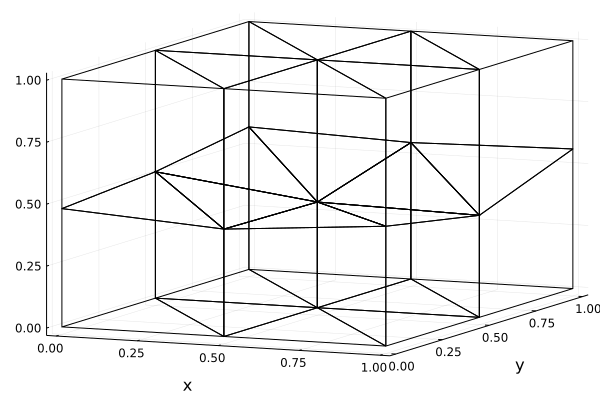

In [13]:
# size of box [0,a]x[0,b]x[0,c]
a = 1
b = 1
c = 1
# theta_z is for "nonuniform" mesh only, theta_z = 0 gives the "uniform" case
theta_z = 30
# mesh can be "uniform", "nonuniform", "terrain" "random"
mesh = "random"
n = 2
p = PlotMesh(mesh, n, n, n, a, b, c, theta_z)
plot(p)
xlabel!("x")
ylabel!("y")
#title!("Prism mesh over [0,1]x[0,1]x[0,1]")

In [14]:
N = 5

mt = zeros(N-1)
H = zeros(N-1)

for i=1:N-1

    nx = i+1
    ny = i+1
    nz = i+1

    Coord_Ns = GetCoordNodes(mesh,nx, ny, nz, a, b, c, theta_z)
    IENf, IENn = GetConnectivity(nx, ny, nz)
    
    max_trace = GetGlobalMaxNormalTrace(Coord_Ns, IENn)
    
    mt[i] = max_trace

    h = Gethsize(Coord_Ns, IENn)
    H[i] = h
end


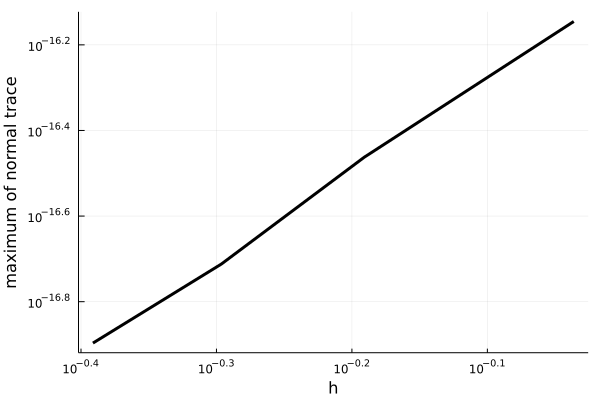

In [15]:
plot(H, mt, xaxis=:log, yaxis=:log, lw = 3, linestyles = :solid, color="black", label = false)
xlabel!("h")
ylabel!("maximum of normal trace")